In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from keras.models import load_model
from PyFunctions import Viz
from PyFunctions import Functions as func

Using plaidml.keras.backend backend.


### Mobilenet

In [ ]:
dim = (224,224)

x_train, x_test, y_train, y_test, x_val, y_val = func.get_mask_splits(dim)

TRAIN Value Counts
1    5000
0    5000
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [3]:
def get_mobilenet(dim):
    model = Sequential()
    optimizer = Adam(lr = .0005)
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(7, 7)))
    model.add(Flatten(name="flatten"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.6))
    model.add(Dense(2, activation="sigmoid", name = 'Output'))

    
    for layer in baseModel.layers:
        layer.trainable = False
        
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=5, min_delta = .00075)
model_checkpoint = ModelCheckpoint(f'ModelWeights/Mobilenet_Masks.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 64
    

dim = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
mobilenet = get_mobilenet(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
mobilenet_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
F:\ProgramFiles\conda\envs\FaceMaskEmotionDetection\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1398 of 2052 operations complete


157/157 [==============================] - 133s 848ms/step - loss: 0.1937 - acc: 0.9206 - val_loss: 0.3634 - val_acc: 0.8478

Epoch 00001: val_loss improved from inf to 0.36340, saving model to ModelWeights/Mobilenet_Masks.h5
Epoch 2/2000
157/157 [==============================] - 86s 550ms/step - loss: 0.0947 - acc: 0.9663 - val_loss: 0.3759 - val_acc: 0.8584

Epoch 00002: val_loss did not improve from 0.36340
Epoch 3/2000
157/157 [==============================] - 90s 576ms/step - loss: 0.0832 - acc: 0.9703 - val_loss: 0.3132 - val_acc: 0.8790

Epoch 00003: val_loss improved from 0.36340 to 0.31321, saving model to ModelWeights/Mobilenet_Masks.h5
Epoch 4/2000
157/157 [==============================] - 90s 574ms/step - loss: 0.0695 - acc: 0.9755 - val_loss: 0.1480 - val_acc: 0.9425

Epoch 00004: val_loss improved from 0.31321 to 0.14802, saving model to ModelWeights/Mobilenet_Masks.h5
Epoch 5/2000
157/157 [==============================] - 90s 573ms/step - loss: 0.0650 - acc: 0.9771 -

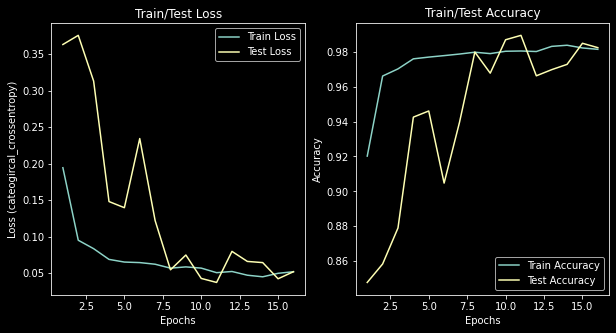

In [7]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'Images/Mobilenet_Loss_Acc.png')

In [ ]:
mobilenet = load_model('ModelWeights/Mobilenet_Masks.h5')
Viz.plot_roc_auc(mobilenet, x_val, y_val, 'dark_background', path = 'Images/Mobilenet_ROC.png')

In [ ]:
def plot_model_cm(test_cm, train_cm, classes,
                          theme, cmap=plt.cm.Blues, path = None, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    plt.style.use(theme)

    if normalize:
        test_cm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
        train_cm = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots(1,2, figsize = (8,8))
    
    #Test Set
    ax[0].imshow(test_cm, interpolation='nearest', cmap=cmap)
    ax[0].set_title('CM for Test')
    tick_marks = np.arange(len(classes))
    ax[0].set_xticks(tick_marks, classes)
    ax[0].set_yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = test_cm.max() / 2.
    for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
        ax[0].text(j, i, format(test_cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if test_cm[i, j] > thresh else "black")

    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylim(2.5, -.5)

    
    
    #Train Set
    ax[1].imshow(train_cm, interpolation='nearest', cmap=cmap)
    ax[1].set_title('CM for Train')
    tick_marks = np.arange(len(classes))
    ax[1].set_xticks(tick_marks, classes)
    ax[1].set_yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = train_cm.max() / 2.
    for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
        ax[1].text(j, i, format(train_cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if train_cm[i, j] > thresh else "black")

    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylim(2.5, -.5)
    
    plt.tight_layout()
    
    if path: 
        plt.savefig(path)
    plt.show()   

In [ ]:
y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

val_prob = [np.argmax(i) for i in mobilenet.predict(x_val)]
val_labels = [np.argmax(i) for i in y_val]
val_cnf = confusion_matrix(val_labels, val_prob)

#this function creates a confusion matrix given the confusion matrixes of test and train
Viz.plot_model_cm(test_cnf, val_cnf, classes = ['No Mask', 'Mask'], theme = 'dark_background')

In [ ]:
assert False

In [ ]:

%%javascript
IPython.notebook.save_notebook()

In [ ]:
os.system(r'%windir%\system32\rundll32.exe powrprof.dll,SetSuspendState Hibernate')